## Applying Natural language processing techniques to classifying a text message as spam and good email (ham) using Python

The data is taken from https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset \
Setps in the data analysis: \
(1) Import relevanlt libraries \
(2) Feature engineering \
(3) Text preprocessing using "stopwords" from NLTK corpus library \
(4) Use CountVectorizer to construct a 2d-matrix from text messages
(5) Building model \
(6) Evaluating a model using confusion matrix


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer


In [3]:
# Download the training data and test data from Kaggle
# Read this page to learn how to download data from Kaggle
# https://www.geeksforgeeks.org/how-to-download-kaggle-datasets-into-jupyter-notebook
#Alternnatively, you can use the code below to directly download the data
#using your kaggle username and kaggle api key

import opendatasets as od
import os
od.download("https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset")           
os.listdir('.')
#os.listdir('brain-tumor-detection')

Skipping, found downloaded files in "./sms-spam-collection-dataset" (use force=True to force download)


['.DS_Store',
 '.ipynb_checkpoints',
 'sms-spam-collection-dataset',
 'NLP_DetectSpamEmail.ipynb']

In [4]:
# read file into pandas using a relative path
df = pd.read_csv("sms-spam-collection-dataset/spam.csv", encoding='latin-1')
df.dropna(how="any", inplace=True, axis=1)
df.columns = ['label', 'message']
print(df.iloc[0:20,:])
print(df.shape)

   label                                            message
0    ham  Go until jurong point, crazy.. Available only ...
1    ham                      Ok lar... Joking wif u oni...
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...
3    ham  U dun say so early hor... U c already then say...
4    ham  Nah I don't think he goes to usf, he lives aro...
5   spam  FreeMsg Hey there darling it's been 3 week's n...
6    ham  Even my brother is not like to speak with me. ...
7    ham  As per your request 'Melle Melle (Oru Minnamin...
8   spam  WINNER!! As a valued network customer you have...
9   spam  Had your mobile 11 months or more? U R entitle...
10   ham  I'm gonna be home soon and i don't want to tal...
11  spam  SIX chances to win CASH! From 100 to 20,000 po...
12  spam  URGENT! You have won a 1 week FREE membership ...
13   ham  I've been searching for the right words to tha...
14   ham                I HAVE A DATE ON SUNDAY WITH WILL!!
15  spam  XXXMobileMovieClub: To use you

In [5]:
df.head()


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [6]:
df.isnull().sum()

label      0
message    0
dtype: int64

In [7]:
print(df['label'].value_counts())
print(df['label'].value_counts().value_counts() )

ham     4825
spam     747
Name: label, dtype: int64
4825    1
747     1
Name: label, dtype: int64


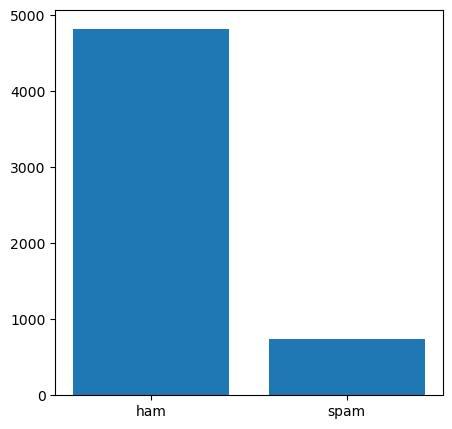

In [8]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.bar( df['label'].value_counts().index, df['label'].value_counts() )
plt.show() 


In [9]:
# convert label to a numerical variable
df['label_num'] = df.label.map({'ham':0, 'spam':1})
df.head()

,label,message,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


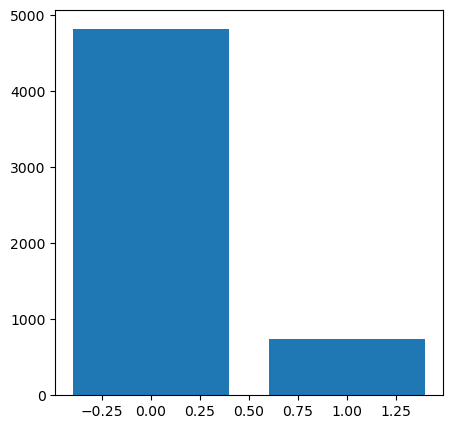

In [10]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.bar( df['label_num'].value_counts().index, df['label_num'].value_counts() )
plt.show() 

In [11]:
#df['message_len'] = df['message'].apply(len)
df['message_word_count'] = df['message'].apply(lambda x: len(x.split(' ')) )

print(df.iloc[1,1])
print(df.head())
print(df.describe())
df.head()

Ok lar... Joking wif u oni...
  label                                            message  label_num  \
0   ham  Go until jurong point, crazy.. Available only ...          0   
1   ham                      Ok lar... Joking wif u oni...          0   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          1   
3   ham  U dun say so early hor... U c already then say...          0   
4   ham  Nah I don't think he goes to usf, he lives aro...          0   

   message_word_count  
0                  20  
1                   6  
2                  28  
3                  11  
4                  13  
         label_num  message_word_count
count  5572.000000         5572.000000
mean      0.134063           15.606784
std       0.340751           11.422465
min       0.000000            1.000000
25%       0.000000            7.000000
50%       0.000000           12.000000
75%       0.000000           23.000000
max       1.000000          171.000000


,label,message,label_num,message_word_count
0,ham,"Go until jurong point, crazy.. Available only ...",0,20
1,ham,Ok lar... Joking wif u oni...,0,6
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28
3,ham,U dun say so early hor... U c already then say...,0,11
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13


Text(0.5, 0, 'Message Word count')

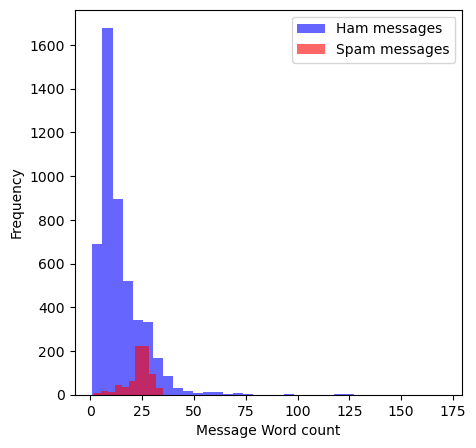

In [12]:
plt.figure(figsize=(5, 5))

df[df.label=='ham'].message_word_count.plot(bins=35, kind='hist', color='blue', 
                                       label='Ham messages', alpha=0.6)
df[df.label=='spam'].message_word_count.plot(kind='hist', color='red', 
                                       label='Spam messages', alpha=0.6)
plt.legend()
plt.xlabel("Message Word count")

#Since the number of feature vector would depend on number of words in each row

In [13]:
# Text Pre-processing using "stopwords" from NLTK corpus library
#Tokenization is a term used to describe the normal text strings into a list of tokens or base words
# As a first step, let's write a function that will split a message into its individual words 
# and return a list. We'll also remove very common words, ('the', 'a', etc..). 
# To do this we will take advantage of the NLTK library. It's pretty much the standard library 
# in Python for processing text and has a lot of useful features. 
# We'll only use some of the basic ones here.

import string
from nltk.corpus import stopwords

def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    STOPWORDS = stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure']

    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in STOPWORDS])

In [14]:
df['base_message'] = df.message.apply(text_process)

df.head()

,label,message,label_num,message_word_count,base_message
0,ham,"Go until jurong point, crazy.. Available only ...",0,20,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,0,6,Ok lar Joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1,28,Free entry wkly comp win FA Cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,0,11,dun say early hor c already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",0,13,Nah think goes usf lives around though


In [15]:
# split X and y into training and testing sets 
from sklearn.model_selection import train_test_split

# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
X = df.base_message
y = df.label_num
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
X_train

(5572,)
(5572,)
(4179,)
(4179,)
(1393,)
(1393,)


710     Height Confidence Aeronautics professors wer c...
3740                                         22 146tf150p
2711    Wen lovable bcums angry wid dnt take seriously...
3155                             Long time remember today
3748    Dear Voucher Holder claim 1st class airport lo...
                              ...                        
905                    Hey whats charles sorry late reply
5192       Oh oh Den muz change plan liao Go back yan jiu
3980                        Huh cant thk oredi many pages
235                         printed oh ltgt come upstairs
5157                                         K k sms chat
Name: base_message, Length: 4179, dtype: object

In [22]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
cv = CountVectorizer()
x_fit = cv.fit(X_train)

# learn training data vocabulary, then use it to create a document-term matrix
X_train_dtm = cv.transform(X_train)

# equivalently: combine fit and transform into a single step
#X_train_dtm = cv.fit_transform(X_train)


# examine the document-term matrix
#print(type(X_train_dtm), X_train_dtm.shape)

# transform testing data (using fitted vocabulary) into a document-term matrix
X_test_dtm = cv.transform(X_test)

#print( X_train_dtm[0][0] )
print(list(x_fit.vocabulary_.items())[0:10])
#print(x_fit.get_feature_names_out())

[('height', 3459), ('confidence', 2013), ('aeronautics', 866), ('professors', 5601), ('wer', 7643), ('calld', 1650), ('amp', 988), ('askd', 1123), ('sit', 6350), ('aeroplane', 867)]


In [23]:
print( len(x_fit.get_feature_names_out()) )
cv.get_feature_names_out()[1000:1020]

7996


array(['andros', 'angels', 'angry', 'animal', 'animation', 'anjie',
       'anjolas', 'anna', 'annie', 'anniversary', 'annoncement',
       'announced', 'announcement', 'annoyin', 'anonymous', 'anot',
       'another', 'ans', 'ansr', 'answer'], dtype=object)

In [24]:
#2d matrix, each row is one message, column's are tokenize vector
X_train_dtm.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [27]:
# Visulaization of matrix examine the vocabulary and document-term matrix together
df_ans = pd.DataFrame(X_train_dtm.toarray(), columns=cv.get_feature_names())
df_ans

/Users/amitkumar/miniconda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,008704050406,0121,01223585236,01223585334,0125698789,020603,02070836089,02072069400,02073162414,02085076972,...,åòits,åômorrow,åôrents,ìll,ìï,ìïll,ûªve,ûïharry,ûò,ûówell
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4175,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4176,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4177,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
# Visulaization of matrix examine the vocabulary and document-term matrix together
df_ans2 = pd.DataFrame(X_train_dtm.toarray(), columns=cv.get_feature_names())
df_ans2.iloc[:,1000:1020]

/Users/amitkumar/miniconda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,andros,angels,angry,animal,animation,anjie,anjolas,anna,annie,anniversary,annoncement,announced,announcement,annoyin,anonymous,anot,another,ans,ansr,answer
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4174,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4175,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4176,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4177,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Model for classification
(1) Logistic Regression \
(2) Decision Tree \
(3) Random Forest \
(4) Support Vector Classifier \
(5) Xtreme Gradient Boosting (xGBoost)

In [30]:
'''
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
'''
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV

In [32]:
#define a function to plot 2x2 confusion matrix
def plot_confusion_matrix(cnf_mat, LabelS, cmap=plt.cm.Blues): 
    fig, ax = plt.subplots(1, 1)
    ims = ax.imshow(cnf_mat, interpolation='nearest', cmap=cmap)
    plt.colorbar(ims, ax=ax)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(LabelS))
    plt.xticks(tick_marks, LabelS, rotation=45)
    plt.yticks(tick_marks, LabelS)
    for i  in range(0,2):
        for j in range(0,2):
            plt.text(i,j,cnf_mat[i][j])

#Retrive classification report and consfusion matrix
from sklearn.metrics import classification_report, confusion_matrix
def EvaluateModel(y_test, y_predict):
    print( classification_report(y_test, y_predict) )
    cnf_mat = confusion_matrix(y_test, y_predict, labels=[0,1])
    print(cnf_mat)
    plot_confusion_matrix(cnf_mat, LabelS=['Ham(0)','Spam(1)'])

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/amitkumar/miniconda/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Logistic Regression 
 BestScore:  0.9782247944302782 
 Best parameters:  {'C': 3792.690190732246, 'max_iter': 2000, 'penalty': 'l2', 'solver': 'liblinear'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3612
           1       1.00      1.00      1.00       567

    accuracy                           1.00      4179
   macro avg       1.00      1.00      1.00      4179
weighted avg       1.00      1.00      1.00      4179

[[3612    0]
 [   0  567]]


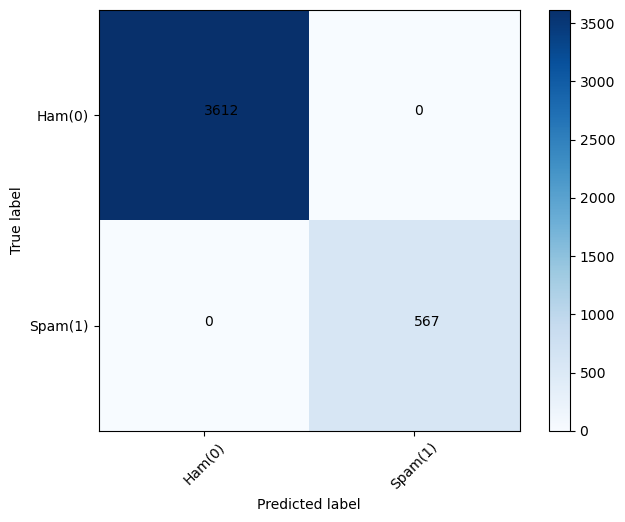

In [34]:
#Use logistic regression model to the data
from sklearn.linear_model import LogisticRegression
import numpy as np

lr = LogisticRegression()
param_grid = {'max_iter' : [2000],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-4, 4, 20),
              'solver' : ['liblinear']}
lr_model = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_lr = lr_model.fit(X_train_dtm, y_train)
print('Logistic Regression', "\n", 
                "BestScore: ", best_lr.best_score_, '\n',
                 "Best parameters: ", best_lr.best_params_ )


#Print confusion matrix
y_predict_lr = lr_model.predict(X_train_dtm)
EvaluateModel(y_train, y_predict_lr) 

#Model predictions
y_test_predict_lr = lr_model.predict(X_test_dtm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
DecisionTreeClassifier 
 BestScore:  0.9593209752743318 
 Best parameters:  {}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3612
           1       1.00      1.00      1.00       567

    accuracy                           1.00      4179
   macro avg       1.00      1.00      1.00      4179
weighted avg       1.00      1.00      1.00      4179

[[3612    0]
 [   0  567]]


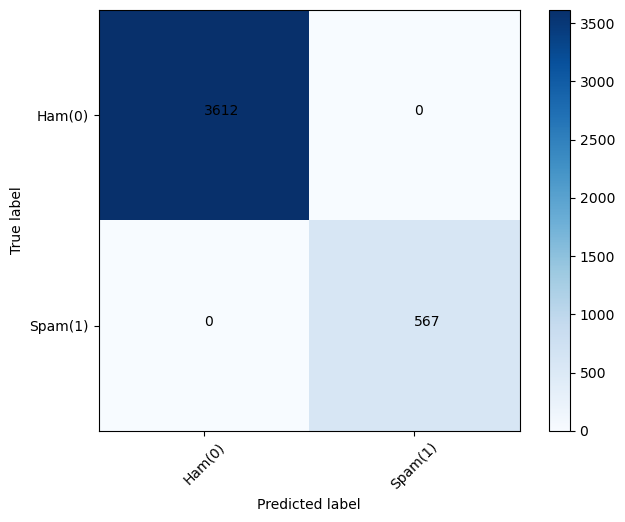

In [36]:
#Using  DecisionTree Classifier to model the data
from sklearn import tree
dct = tree.DecisionTreeClassifier()
param_grid = { } #'criterion':['gini','entropy'],'max_depth': np.arange(3, 15)}
dct_model = GridSearchCV(dct, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_dct = dct_model.fit(X_train_dtm, y_train)
print('DecisionTreeClassifier', "\n", 
                "BestScore: ", best_dct.best_score_, '\n',
                 "Best parameters: ", best_dct.best_params_ )


#Print confusion matrix
y_predict_dct = dct_model.predict(X_train_dtm)
EvaluateModel(y_train, y_predict_dct) 

#Model predictions
y_test_predict_dct = dct_model.predict(X_test_dtm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
RandomForestClassifier 
 BestScore:  0.9679331289573962 
 Best parameters:  {}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3612
           1       1.00      1.00      1.00       567

    accuracy                           1.00      4179
   macro avg       1.00      1.00      1.00      4179
weighted avg       1.00      1.00      1.00      4179

[[3612    0]
 [   0  567]]


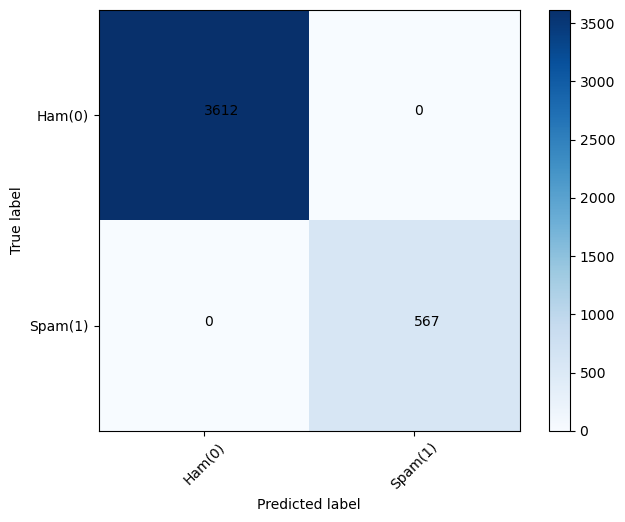

In [39]:
#Using  RandomForest  Classifier to model the data
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0)
param_grid = { } 
'''
                'n_estimators': [200, 400],
                'criterion':['gini','entropy'],
                'bootstrap': [True],
                'max_depth': [15],
                'max_features': ['auto', 'sqrt'],
                'min_samples_leaf': [2],
                'min_samples_split': [2]}
                '''
rfc_model = GridSearchCV(rfc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_rfc = rfc_model.fit(X_train_dtm, y_train)
print('RandomForestClassifier', "\n", 
                "BestScore: ", best_rfc.best_score_, '\n',
                 "Best parameters: ", best_rfc.best_params_ )


#Print confusion matrix
y_predict_rfc = rfc_model.predict(X_train_dtm)
EvaluateModel(y_train, y_predict_rfc) 

#Model predictions
y_test_predict_rfc = rfc_model.predict(X_test_dtm)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
SupportVectorClassifier 
 BestScore:  0.9782247944302782 
 Best parameters:  {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3612
           1       1.00      1.00      1.00       567

    accuracy                           1.00      4179
   macro avg       1.00      1.00      1.00      4179
weighted avg       1.00      1.00      1.00      4179

[[3612    0]
 [   0  567]]


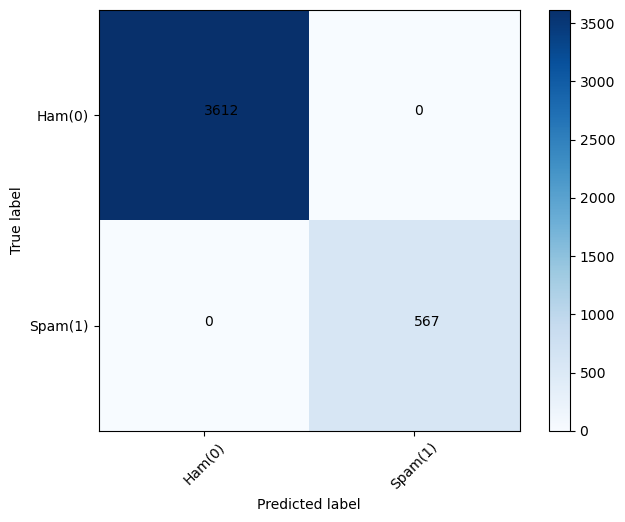

In [40]:
#Using  Support vector  Classifier to model the data
from sklearn.svm import SVC

svc = SVC(random_state=0)
param_grid = {  'C': [0.1, 1, 10, 100, 1000], 
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf'] }
svc_model = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True)
best_svc = svc_model.fit(X_train_dtm, y_train)
print('SupportVectorClassifier', "\n", 
                "BestScore: ", best_svc.best_score_, '\n',
                 "Best parameters: ", best_svc.best_params_ )


#Print confusion matrix
y_predict_svc = svc_model.predict(X_train_dtm)
EvaluateModel(y_train, y_predict_svc) 

#Model predictions
y_test_predict_svc = svc_model.predict(X_test_dtm)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
xGBoost Classifier 
 BestScore:  0.9720024066699138 
 Best parameters:  {'gamma': 0.1, 'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0}
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3612
           1       1.00      0.88      0.94       567

    accuracy                           0.98      4179
   macro avg       0.99      0.94      0.96      4179
weighted avg       0.98      0.98      0.98      4179

[[3611    1]
 [  66  501]]


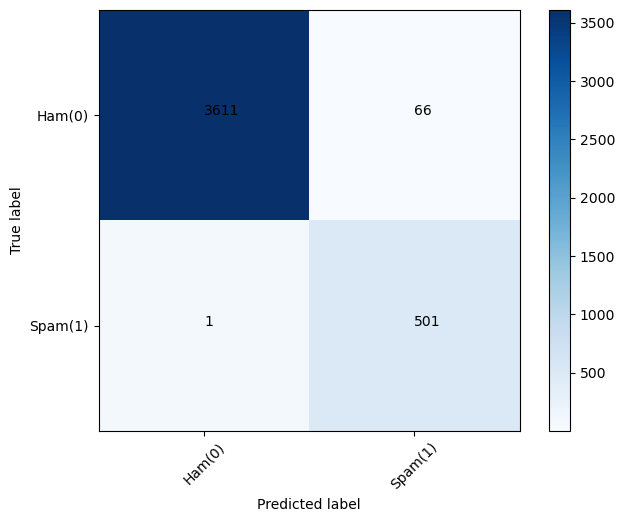

In [43]:
#Using  xGBoost (ExtremeGradientBoost)  Classifier to model the data
import xgboost as xgb

xgbc = xgb.XGBClassifier(random_state=0)
param_grid = {
              'gamma': [0,0.1, 200],
              'learning_rate': [0.01,  0.3],
              'max_depth': [5],
              'n_estimators': [50],
              'reg_alpha': [0,0.1],
              'reg_lambda': [0,0.1]}
#'''
xgbc_model = GridSearchCV(xgbc, param_grid = param_grid, cv = 5, verbose = True)
best_xgbc = xgbc_model.fit(X_train_dtm, y_train)
print('xGBoost Classifier', "\n", 
                "BestScore: ", best_xgbc.best_score_, '\n',
                 "Best parameters: ", best_xgbc.best_params_ )


#Print confusion matrix
y_predict_xgbc = xgbc_model.predict(X_train_dtm)
EvaluateModel(y_train, y_predict_xgbc) 

#Model predictions
y_test_predict_xgbc = xgbc_model.predict(X_test_dtm)

### Each model gives an accuracy of 98% or aboove.